In [1]:
import pandas as pd

df = pd.read_csv("../customer_support_tickets.csv")

# Build an AI model to categorize user intent based on the ticket. 
Q1: Design an AI or GenAI solution to categorize customer inquiries into different intent categories. How would you design an unsupervised learning model or generative AI model to discover new categories of customer inquiries, given that we don't have a clear categories list?
- Use Ticket Type, Ticket Subject, and Ticket Description to understand the user inquiries.
- Given that we do not have the clear category list, we can semantic embed the ticket content and clustering, then determine the group title based on top-k typical ticket

First, I would build a unsupervised solution using semantic embedding and clustering

**Process:**
- Preprocess the ticket description
- Use sentence embedding on ticket type, ticket subject, and ticket description
- Concatenate ticket type, subject, and description, then generate the representation for ticket content
- Use K-mean clustering to determine the clusters and typical tickets for each group
- Use Gen AI/human intuition to label the intent for each ticket group

In [2]:
import re
import nltk
import spacy
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from transformers import AutoTokenizer
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter

# Remove non-informative phrase
phrases_to_remove = [
    r"i'?m having an issue with (the )?\{?product_purchased\}?\s*\.?",
    r"please assist\.?",
    r"let me know\.?",
    r"thank you\.?",
]
phrase_pattern = re.compile(r"|".join(phrases_to_remove), re.IGNORECASE)

def clean_text(text):
    text = phrase_pattern.sub("", text)
    text = re.sub(r"\s+", " ", text)

    return text

def ticket_content_wrapper(ticket):
    return f'Ticket Type: {ticket["Ticket Type"]}, Ticket Subject: {ticket["Ticket Subject"]}, Ticket Description: {ticket["Ticket Description Processed"]}'
    
df = df.drop_duplicates(subset="Ticket Description", keep="first")
df["Ticket Description Processed"] = df["Ticket Description"].apply(clean_text)
df['Ticket Content'] = df.apply(ticket_content_wrapper, axis=1)

In [3]:
df['Ticket Content']

0       Ticket Type: Technical issue, Ticket Subject: ...
1       Ticket Type: Technical issue, Ticket Subject: ...
2       Ticket Type: Technical issue, Ticket Subject: ...
3       Ticket Type: Billing inquiry, Ticket Subject: ...
4       Ticket Type: Billing inquiry, Ticket Subject: ...
                              ...                        
8464    Ticket Type: Product inquiry, Ticket Subject: ...
8465    Ticket Type: Technical issue, Ticket Subject: ...
8466    Ticket Type: Technical issue, Ticket Subject: ...
8467    Ticket Type: Product inquiry, Ticket Subject: ...
8468    Ticket Type: Billing inquiry, Ticket Subject: ...
Name: Ticket Content, Length: 8077, dtype: object

In [4]:
#Construct dataset and dataloader from the given ticket dataset
class TicketDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            "idx": idx, 
            "desc": row["Ticket Description Processed"],
            "subj": row["Ticket Subject"],
            "type": row["Ticket Type"]
        }

def collate_fn(batch):
    texts = [f'Ticket Type: {item["type"]}, Ticket Subject: {item["subj"]}, Ticket Description: {item["desc"]}' for item in batch]
    tokenized = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    idxs = [item["idx"] for item in batch]
    return tokenized, idxs

In [5]:
#Generate embedding for ticket content
from transformers import AutoTokenizer, T5EncoderModel
from sklearn.metrics.pairwise import cosine_similarity

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/sentence-t5-base")
model = T5EncoderModel.from_pretrained("sentence-transformers/sentence-t5-base").to(device)
model.eval()

dataset = TicketDataset(df)  
dataloader = DataLoader(dataset, batch_size=8, collate_fn=collate_fn)

# Computes a sentence embedding by averaging the token embeddings while ignoring padded tokens
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return (token_embeddings * input_mask_expanded).sum(1) / input_mask_expanded.sum(1)

# Generate sentence embeddings
embeddings = []
with torch.no_grad():
    for tokenized, idxs in dataloader:
        for k in tokenized:
            tokenized[k] = tokenized[k].to(device)
        model_output = model(**tokenized)
        pooled = mean_pooling(model_output, tokenized['attention_mask'])
        embeddings.append(pooled.cpu())

sentence_embeddings = torch.cat(embeddings, dim=0) 

In [6]:
sentence_embeddings.shape

torch.Size([8077, 768])

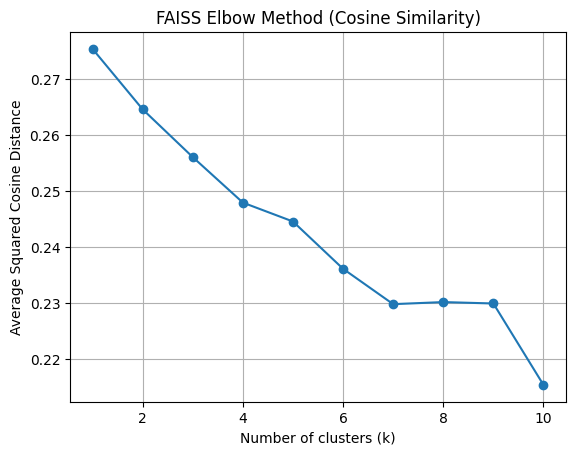

In [7]:
# After having the ticket embeddings, applying Kmeans with elbow to seek for the optimal number of k
import matplotlib.pyplot as plt
import faiss
import numpy as np

# Convert embeddings to numpy
X = sentence_embeddings.numpy().astype('float32')
faiss.normalize_L2(X)

# Try k from 1 to 10
k_range = range(1, 11)
avg_distance = []

for k in k_range:
    kmeans = faiss.Kmeans(d=X.shape[1], k=k, niter=20, verbose=False)
    kmeans.train(X)
    
    # Search for nearest centroid (1-NN)
    D, _ = kmeans.index.search(X, 1)  
    avg_distance.append(np.mean(D)) 

# Plot the elbow curve
plt.figure()
plt.plot(k_range, avg_distance, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Squared Cosine Distance')
plt.title('FAISS Elbow Method (Cosine Similarity)')
plt.grid(True)
plt.show()

No clear elbow point is observed, although choosing 5 clusters appears to be a reasonable option. This matches the number of ticket type. 
- Retrieve and check top-k typical tickets for each cluster to determine the label

In [8]:
k = 5  
top_k = 5

kmeans = faiss.Kmeans(d=X.shape[1], k=k, niter=20, verbose=False)
kmeans.train(X)
_, labels = kmeans.index.search(X, 1)
labels = labels.flatten()

# Find typical (closest) tickets per cluster
typical_tickets = {}

for cluster_id in range(k):
    cluster_indices = np.where(labels == cluster_id)[0]
    cluster_vectors = X[cluster_indices]
    
    # Cosine similarity = dot product (since vectors are normalized)
    centroid = kmeans.centroids[cluster_id].reshape(1, -1)
    similarities = np.dot(cluster_vectors, centroid.T).flatten()
    
    # Get top-k indices with highest similarity
    top_k_indices = cluster_indices[np.argsort(similarities)[-top_k:][::-1]]  # descending order
    typical_tickets[cluster_id] = df.iloc[top_k_indices]

In [9]:
df["Ticket Subject"].unique()

array(['Product setup', 'Peripheral compatibility', 'Network problem',
       'Account access', 'Data loss', 'Payment issue', 'Refund request',
       'Battery life', 'Installation support', 'Software bug',
       'Hardware issue', 'Product recommendation', 'Delivery problem',
       'Display issue', 'Cancellation request', 'Product compatibility'],
      dtype=object)

In [10]:
for i in range(k):
    typicals = typical_tickets[i]
    print(f"\n=== Cluster {i} - Top {len(typicals)} Typical Tickets ===\n")
    for j, row in typicals.iterrows():
        print(f"Ticket {j+1}:")
        print(f"  Type    : {row['Ticket Type']}")
        print(f"  Subject : {row['Ticket Subject']}")
        print(f"  Content : {row['Ticket Content']}\n")


=== Cluster 0 - Top 5 Typical Tickets ===

Ticket 5900:
  Type    : Product inquiry
  Subject : Payment issue
  Content : Ticket Type: Product inquiry, Ticket Subject: Payment issue, Ticket Description: I'm facing a problem with my {product_purchased}. The {product_purchased} is not turning on. It was working fine until yesterday, but now it doesn't respond. Why was there no {product_ I've checked for software updates, and my {product_purchased} is already running the latest version.

Ticket 3181:
  Type    : Billing inquiry
  Subject : Software bug
  Content : Ticket Type: Billing inquiry, Ticket Subject: Software bug, Ticket Description: I'm facing a problem with my {product_purchased}. The {product_purchased} is not turning on. It was working fine until yesterday, but now it doesn't respond. If it's already going to work it will I've checked the device settings and made sure that everything is configured correctly.

Ticket 1553:
  Type    : Product inquiry
  Subject : Software bug


In [11]:
df["label"] = labels
for i in range(k):
    insight = df[df["label"] == i]
    print(len(insight))
    print(f"Statistics for group {i}")    
    print(insight["Ticket Type"].value_counts())
    

2352
Statistics for group 0
Ticket Type
Billing inquiry    806
Product inquiry    802
Technical issue    744
Name: count, dtype: int64
2186
Statistics for group 1
Ticket Type
Refund request          973
Cancellation request    868
Technical issue         127
Product inquiry         117
Billing inquiry         101
Name: count, dtype: int64
1696
Statistics for group 2
Ticket Type
Cancellation request    402
Technical issue         385
Refund request          332
Product inquiry         299
Billing inquiry         278
Name: count, dtype: int64
686
Statistics for group 3
Ticket Type
Billing inquiry         146
Technical issue         142
Cancellation request    141
Refund request          138
Product inquiry         119
Name: count, dtype: int64
1157
Statistics for group 4
Ticket Type
Technical issue         253
Product inquiry         240
Billing inquiry         240
Refund request          216
Cancellation request    208
Name: count, dtype: int64


From the statistics, it seems that the tickets can also be categorized into 2 high-level categories: [Technical issue, Product inquiry, Billing inquiry] and [Refund request, Cancellation request]. I propose to group [Technical issue, Product inquiry, Billing inquiry] as "Service Help" and [Refund request, Cancellation request] as "Cancellation and Refund".

Solution 2: Use a LLM to determine the user intent based on the ticket content. 
- Use NLI model to determine the user intent from the ticket description

In [12]:
from transformers import pipeline

# Load zero-shot classification pipeline
intent_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device = device)
# Candidate intents
user_intents = [
    "Help with Product Setup",
    "Check Peripheral Compatibility",
    "Resolve Network Problem",
    "Recover Account Access",
    "Report Data Loss",
    "Fix Payment Issue",
    "Request Refund",
    "Battery Draining Too Fast",
    "Need Installation Support",
    "Report Software Bug",
    "Report Hardware Issue",
    "Ask for Product Recommendation",
    "Report Delivery Problem",
    "Fix Display Issue",
    "Request Cancellation",
    "Check Product Compatibility"
]

def retrieve_user_intent(text, classifier, user_intents = user_intents, verbose = False):

    result = classifier(text, user_intents, multi_label=True)
    
    if verbose:
        print("Predicted Intents:")
        for label, score in zip(result['labels'], result['scores']):
            print(f"{label}: {score:.3f}")

    return result['labels'][0]


In [13]:
#Test with some tickets
import random

for i in range(3):   
    rand_num = random.randint(0, len(df))
    item = df.iloc[rand_num]
    ticket_content = ticket_content_wrapper(item)
    print(ticket_content)
    intent = retrieve_user_intent(ticket_content, intent_classifier, user_intents, verbose = False)
    print("User intent:", intent)
    print("-" * 40)

Ticket Type: Refund request, Ticket Subject: Display issue, Ticket Description: I've recently set up my {product_purchased}, but it fails to connect to any available networks. What steps should I take to troubleshoot this issue? If you're the user that's using Microsoft Windows Media Encoder I've tried different settings and configurations on my {product_purchased}, but the issue persists.
User intent: Request Refund
----------------------------------------
Ticket Type: Technical issue, Ticket Subject: Display issue, Ticket Description:  There were three or four people in the room, and they all took the keys, and he was completely quiet... it looked like in the very background. I've tried troubleshooting steps mentioned in the user manual, but the issue persists.
User intent: Fix Display Issue
----------------------------------------
Ticket Type: Cancellation request, Ticket Subject: Cancellation request, Ticket Description: I've accidentally deleted important data from my {product_pur

Q2: Given the "Customer Age" and "Customer Gender" fields, how might you personalize the AI model's responses to different customer segments?
- Categorize customers by age (young, middle-age, elderly) and gender (male, female), and provide this context to the Gen AI model.
- Select high-rated resolutions as examples for each customer group.

In [14]:
df["Customer Age"].describe()

count    8077.000000
mean       44.037266
std        15.262633
min        18.000000
25%        31.000000
50%        44.000000
75%        57.000000
max        70.000000
Name: Customer Age, dtype: float64

In [15]:
df.loc[df["Customer Age"] < 30, "Customer Age Group"] = "Younger"
df.loc[(df["Customer Age"] >= 30) & (df["Customer Age"] < 45), "Customer Age Group"] = "Middle"
df.loc[df["Customer Age"] >= 45, "Customer Age Group"] = "Elder"

In [16]:
df["Customer Gender"].value_counts()

Customer Gender
Female    2755
Male      2750
Other     2572
Name: count, dtype: int64

The customer can be categorized into 3 group ages: Young, Middle, Elder; and 3 genders. I use the rule-based as follow to personalized the chatbot: 
- Younger: use casual tone
- Middle: use balanced tone; with empathic tone for woman, efficient tone for men and neutral tone for other
- Elder: use formal, respectful tone


In [17]:
template = """
You are a helpful and respectful customer support assistant.

The following information is provided about the user:
- Purchased product: {product}
- User Intent: {intent}
Customer's message: "{ticket_content}"

Based on the above, provide brief relevant assistance. {tone}
"""

def select_tone(ticket):
    age_group = ticket["Customer Age Group"]
    gender = ticket["Customer Gender"]
    if age_group == "Younger":
        return "Respond in a casual and friendly tone suitable for younger audiences."
    elif age_group == "Middle":
        if gender == "Female":
            return "Respond in a balanced, empathetic tone."
        elif gender == "Male":
            return "Respond in a balanced, efficient tone."
        else:
            return "Respond in a balanced, neutral tone."
    else:
        return "Respond in a formal, respectful tone suitable for older customers."

def prepare_input_data(ticket, user_intent_classifier, template=template):
    age_group = ticket["Customer Age Group"]
    gender = ticket["Customer Gender"]
    product = ticket["Product Purchased"]
    ticket_content = ticket_content_wrapper(ticket)
    user_intent = retrieve_user_intent(ticket_content, user_intent_classifier)
    tone = select_tone(ticket)
    
    input_data = {
        "product": product,
        "ticket_content": ticket_content,
        "intent": user_intent,
        "tone": tone
    }

    return input_data    


In [18]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI

prompt = PromptTemplate.from_template(template)
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.5)
chain = prompt | llm


In [19]:
ticket = df.iloc[6]
input_data = prepare_input_data(ticket, intent_classifier)
print(input_data)

response = chain.invoke(input_data)
print("\nAssistant:", response.content)

{'product': 'Microsoft Surface', 'ticket_content': "Ticket Type: Product inquiry, Ticket Subject: Refund request, Ticket Description: I'm unable to access my {product_purchased} account. It keeps displaying an 'Invalid Credentials' error, even though I'm using the correct login information. How can I regain access to my account? Solution 1 I'm unable to find the option to perform the desired action in the {product_purchased}. Could you please guide me through the steps?", 'intent': 'Request Refund', 'tone': 'Respond in a casual and friendly tone suitable for younger audiences.'}

Assistant: Hey there! I'm sorry to hear you're having trouble accessing your Microsoft Surface account. It sounds like you're getting an 'Invalid Credentials' error, even though you're using the right login info. Let's get this sorted out for you! 

First, let's try resetting your password. You can usually do this by clicking on the 'Forgot Password' link on the login page. If that doesn't work, you can reach 

Q3: How would you come up with new features to determine which queries should be escalated to human operators? For example, we can decide a ticket should be escalated if it has high or critical priority, can you think of something else?
- Beside the priority, user intent can be used to decide if the query should be escalated to human operator
- Also, we can use content-based feature: e.g. if the ticket is really negative?
  
As the "Human Escalated" labels are not available, I propose a heuristic to label the tickets using ticket sentiment, user intent and ticket priority

In [20]:
escalated_intents = [
    "Recover Account Access",       # Critical for user access
    "Report Data Loss",             # Potentially irreversible loss
    "Fix Payment Issue",            # Involves financial sensitivity
    "Request Refund",               # May involve policy exceptions
    "Report Hardware Issue",        # Needs diagnostics or replacement
    "Report Software Bug",          # Technical issue, may need logging/debugging
    "Request Cancellation",         # Retention-sensitive, may need confirmation
    "Report Delivery Problem"       # Time-sensitive and frustrating for users
]

non_escalated_intents = [
    "Help with Product Setup",          # Routine onboarding
    "Resolve Network Problem",          # Medium priority troubleshooting
    "Battery Draining Too Fast",        # Performance-related but not critical
    "Fix Display Issue",                # Visual/UX issue, typically fixable
    "Need Installation Support",        # Basic guidance
    "Check Peripheral Compatibility",   # Informational query
    "Check Product Compatibility",      # Informational query
    "Ask for Product Recommendation"    # Low-stakes query
]


The below code to preprocess the data and retrieve user intent and ticket sentiment score using facebook-bart-nli and Hugging Face sentiment analyzer. It has been pre-run and save the result to csv file 

In [21]:
# from tqdm import tqdm
# intents = []

# def retrieve_user_intents_batch(texts, classifier, user_intents=user_intents):
#     results = classifier(texts, user_intents, multi_label=True)
    
#     predicted_labels = []
#     for i, result in enumerate(results):
#         top_label = result['labels'][0]
#         predicted_labels.append(top_label)

#     return predicted_labels
    
# sentiment_analyzer = pipeline("sentiment-analysis", device = device)

# def retrieve_ticket_sentiment_batch(texts, classifier):
#     try:
#         results = classifier(list(texts))  # Ensure it's a list
#     except Exception as e:
#         print(f"Error during classification: {e}")
#         return [], []
    
#     predicted_labels = []
#     predicted_scores = []

#     for result in results:
#         label = result.get('label', 'UNKNOWN')
#         score = result.get('score', 0.0)
#         predicted_labels.append(label)
#         predicted_scores.append(score)

#     return predicted_labels, predicted_scores

# batch_size = 32
# intents = []

# ticket_texts = [ticket_content_wrapper(row) for _, row in df.iterrows()]

# for i in tqdm(range(0, len(ticket_texts), batch_size)):
#     batch = ticket_texts[i:i+batch_size]
#     batch_intents = retrieve_user_intents_batch(batch, intent_classifier, user_intents)
#     intents.extend(batch_intents)

# df['user_intent'] = intents

# labels = []
# scores = []
# ticket_contents = df["Ticket Content"].dropna().values
# batch_size = 32  

# # Loop over batches
# for i in tqdm(range(0, len(ticket_contents), batch_size)):
#     batch = ticket_contents[i:i+batch_size]
#     t_labels, t_scores = retrieve_ticket_sentiment_batch(batch, sentiment_analyzer)
#     labels.extend(t_labels)
#     scores.extend(t_scores)

# df["Ticket Sentiment"] = labels
# df["Ticket Sentiment Score"] = scores
# df.to_csv("../customer_support_tickets_processed.csv")

In [22]:
df = pd.read_csv("../customer_support_tickets_processed.csv", index_col = "Ticket ID")

In [23]:
df.head()

,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,...,First Response Time,Time to Resolution,Customer Satisfaction Rating,Ticket Content,label,Customer Age Group,User Intent,Ticket Sentiment,Ticket Sentiment Score,Ticket Description Processed
Ticket ID,,,,,,,,,,,,,,,,,,,,,
1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,...,2023-06-01 12:15:36,NaN,NaN,"Ticket Type: Technical issue, Ticket Subject: ...",4,Middle,Help with Product Setup,NEGATIVE,0.994166,Your billing zip code is: 71701. We appreciat...
2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,...,2023-06-01 16:45:38,NaN,NaN,"Ticket Type: Technical issue, Ticket Subject: ...",4,Middle,Check Peripheral Compatibility,NEGATIVE,0.693675,If you need to change an existing product. If...
3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,...,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0,"Ticket Type: Technical issue, Ticket Subject: ...",2,Elder,Resolve Network Problem,NEGATIVE,0.999586,I'm facing a problem with my {product_purchase...
4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,...,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0,"Ticket Type: Billing inquiry, Ticket Subject: ...",4,Younger,Recover Account Access,NEGATIVE,0.990158,If you have a problem you're interested in an...
5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,...,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0,"Ticket Type: Billing inquiry, Ticket Subject: ...",2,Elder,Battery Draining Too Fast,NEGATIVE,0.997348,Note: The seller is not responsible for any d...


In [24]:
df["Ticket Sentiment"].value_counts()

Ticket Sentiment
NEGATIVE    7495
POSITIVE     543
Name: count, dtype: int64

In [25]:
df[df["Ticket Sentiment"] == "NEGATIVE"]["Ticket Sentiment Score"].describe()

count    7495.000000
mean        0.987993
std         0.049115
min         0.507280
25%         0.997095
50%         0.999082
75%         0.999631
max         0.999823
Name: Ticket Sentiment Score, dtype: float64

In [26]:
len(df[(df["Ticket Sentiment"] == "NEGATIVE") & (df["Ticket Sentiment Score"] > 0.95)])

7146

Most of the ticket are negative with high score, so I use the following rule: if the tickets are satisfied all of the following:
- User intent in escalated_intents
- Negative ticket with high score (>0.95)
- Priority is Critical or High

In [27]:
sentiment_condition = (df["Ticket Sentiment"] == "NEGATIVE") & (df["Ticket Sentiment Score"] > 0.95)
priority_condition = df["Ticket Priority"].isin(["Critical", "High"])
intent_condition = df["User Intent"].isin(escalated_intents)

filtered_df = df[sentiment_condition & priority_condition & intent_condition]

In [28]:
len(filtered_df) / len(df)

0.3215974122916148

Around 30% of the ticket is escalated to human, which is a reasonable number

In [29]:
df["Human Escalated"] = False
df.loc[sentiment_condition & priority_condition & intent_condition, "Human Escalated"] = True

In [30]:
for d in df[df["Human Escalated"]].tail(5)["Ticket Content"]:
    print(d)
    print("-" * 40)

Ticket Type: Billing inquiry, Ticket Subject: Display issue, Ticket Description: I've accidentally deleted important data from my {product_purchased}. Is there any way to recover the deleted files? I need them urgently. Your Name should also be included in the account list. I did not have any data or This problem started occurring after the recent software update. I haven't made any other changes to the device.
----------------------------------------
Ticket Type: Refund request, Ticket Subject: Display issue, Ticket Description:  You were able to purchase the product at the store. Please report any problems you can. Sorry, there are no items for purchase. I've already contacted customer support multiple times, but the issue remains unresolved.
----------------------------------------
Ticket Type: Technical issue, Ticket Subject: Refund request, Ticket Description:  Sell for 30-35% (I also bought a 2.5mm and I'm getting stuck). Buy for 80-100% ( The issue I'm facing is intermittent. So

Since the 'Human Escalated' label is generated by a rule-based system using sentiment, priority, and intent, and produces reasonable results, we can use it as a pipeline to determine whether a ticket should be escalated to a human. However, I will attempt to build an AI model that classifies tickets based solely on their content, using the rule-based labels as targets, to evaluate whether the classifier can achieve high performance.

In [31]:
sentence_embeddings.shape

torch.Size([8077, 768])

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TicketEscalationClassifier(nn.Module):
    def __init__(self, embedding_dim):
        super(TicketEscalationClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x)).squeeze(1)  
        return x    

def collate_fn(batch):
    idxs = [item["idx"] for item in batch]
    labels = [item["Human Escalated"] for item in batch]
    return idxs, labels

In [33]:
df["Human Escalated"]

Ticket ID
1       False
2       False
3       False
4       False
5       False
        ...  
8465    False
8466     True
8467     True
8468    False
8469     True
Name: Human Escalated, Length: 8038, dtype: bool

In [34]:
#Redefine ticket dataset with Human Escalated label
class TicketDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            "idx": idx, 
            "label": row["Human Escalated"].astype(int)
        }

def collate_fn(batch):
    idxs = [item["idx"] for item in batch]
    labels = [float(item["label"]) for item in batch]
    return torch.tensor(idxs), torch.tensor(labels)

In [35]:
from torch.utils.data import random_split, DataLoader

dataset = TicketDataset(df)  
dataloader = DataLoader(dataset, batch_size=16, collate_fn=collate_fn)

total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # Ensure all data is used

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [44]:
import torch.nn as nn
import torch.optim as optim

pretrained_sentence_embeddings = sentence_embeddings #Sentence embeddings pretrained by sentence-T5
learning_rate = 1e-4

model = TicketEscalationClassifier(embedding_dim = pretrained_sentence_embeddings.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for idxs, labels in train_loader:
        inputs = pretrained_sentence_embeddings[idxs]
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()       
        
    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for idxs, labels in val_loader:
            inputs = pretrained_sentence_embeddings[idxs]
            inputs, labels = inputs.to(device), labels.to(device)
            
            logits = model(inputs)
            preds = (torch.sigmoid(logits) > 0.5).long()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")

with torch.no_grad():
    for idxs, labels in test_loader:
        inputs = pretrained_sentence_embeddings[idxs]
        inputs, labels = inputs.to(device), labels.to(device)
        
        logits = model(inputs)
        preds = (torch.sigmoid(logits) > 0.5).long()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Test Accuracy = {test_accuracy:.4f}")

Epoch 1: Train Loss = 0.7585, Val Accuracy = 0.3263
Epoch 2: Train Loss = 0.7062, Val Accuracy = 0.3263
Epoch 3: Train Loss = 0.6974, Val Accuracy = 0.3263
Epoch 4: Train Loss = 0.6950, Val Accuracy = 0.3263
Epoch 5: Train Loss = 0.6941, Val Accuracy = 0.3263
Epoch 6: Train Loss = 0.6938, Val Accuracy = 0.3263
Epoch 7: Train Loss = 0.6935, Val Accuracy = 0.3263
Epoch 8: Train Loss = 0.6934, Val Accuracy = 0.3263
Epoch 9: Train Loss = 0.6933, Val Accuracy = 0.3263
Epoch 10: Train Loss = 0.6933, Val Accuracy = 0.3263
Test Accuracy = 0.3097


It seems that the ticket content does not provide enough context to predict the labels, as it lacks information about priority. So I suggest combine the sentiment, priority and user intent for detecting escalated tickets.